# QCut Basic Usage

In [1]:
import QCut as ck
from QCut import cut
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator

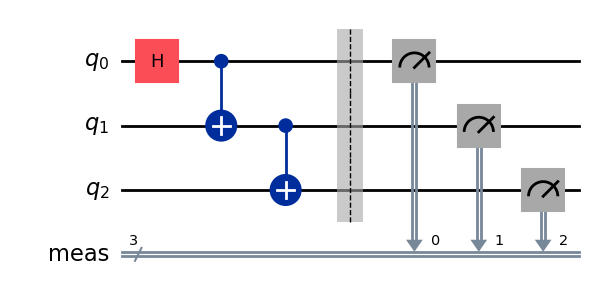

In [2]:
#define initial circuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure_all()

circuit.draw("mpl")

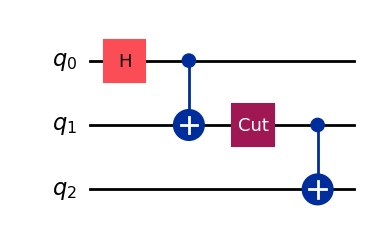

In [3]:
#insert cut

cut_circuit = QuantumCircuit(3)
cut_circuit.h(0)
cut_circuit.cx(0,1)
cut_circuit.append(cut, [1])
cut_circuit.cx(1,2)

cut_circuit.draw("mpl")

In [4]:
#find cut locations and separate into subcircuits

cut_locations, subcircuits, map_qubit = ck.get_locations_and_subcircuits(cut_circuit)

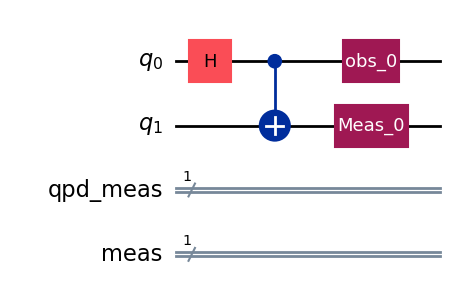

In [5]:
subcircuits[0].draw("mpl")

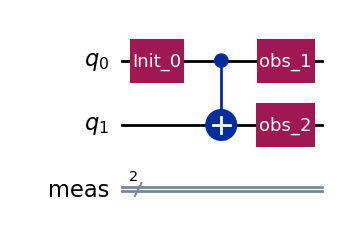

In [6]:
subcircuits[1].draw("mpl")

In [7]:
#insert qpd operations to get the 8^n experiment circuits, where n is the number of cuts made
#also returns coefficients used for reconstructing the expectation values
#and locations of identity basis measurements that get added with post processing

experiment_circuits, coefficients, id_meas = ck.get_experiment_circuits(subcircuits, cut_locations)

In [8]:
#define backend
backend = AerSimulator()

In [9]:
#run experiment circuits
#run_experiments() also post processes the results

results = ck.run_experiments(experiment_circuits, cut_locations, id_meas, backend=backend)

In [10]:
#define observables to calculate expectation values for
observables = [0,1,2, [0,2]]

#get the approximated expectation values
expectation_values = ck.estimate_expectation_values(results, coefficients, cut_locations, observables, map_qubit)

In [11]:
#transform observables into a PauliList for the Qiskit Estimator
paulilist_observables = ck.get_pauli_list(observables, 3)

#get the exact expectation values with ideal simulator
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(paulilist_observables),  # noqa: PD011
                  list(paulilist_observables)).result().values
)

In [12]:
import numpy as np

#set numpy print options
np.set_printoptions(formatter={"float": lambda x: f"{x:0.6f}"})
expectation_values = np.array(expectation_values).astype(float)

#compare QCut to Estimator
print(f"QCut circuit knitting expectation values:{np.array(expectation_values)}")
print(f"Exact expectation values with ideal simulator :{np.array(exact_expvals)}")


QCut circuit knitting expectation values:[-0.004397 -0.004397 -0.016602 0.987260]
Exact expectation values with ideal simulator :[0.000000 0.000000 0.000000 1.000000]
